In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import gridspec
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, matthews_corrcoef, roc_auc_score

from src.downstream.utils import multioutput_mcc

In [2]:
SPLIT = "valid"
SPLIT_ID = {"train": 0, "valid": 1, "test": 2}[SPLIT]

MODELS = ["esm_t6", "esm_t12", "esm_t30", "esm_t33", "esm_t36", "ankh-base", "ankh-large", "prostt5", "ohe"]
DATASETS = ["fluorescence", "stability", "deeploc2", "deeploc2_bin"]
ALGOS = ["lr", "knn"]
LAYERS = {
    "esm_t6": 6,
    "esm_t12": 12,
    "esm_t30": 30,
    "esm_t33": 33,
    "esm_t36": 36,
    "ankh-base": 48,
    "ankh-large": 48,
    "prostt5": 24,
    "ohe": 0,
}
# 245 model layers x 3 datasets = 735 ID computations

LINES = {
    "id": "dotted",
    "lr": "-",
    "knn": "--"
}
DS_COLORS = {
    "fluorescence": "b",
    "stability": "r",
    "deeploc2": "orange",
    "deeploc2_bin": "g",
}

REG_METRIC = "rmse"
CLASS_METRIC = "AUROC"
ROOT = Path("/") / "scratch" / "SCRATCH_SAS" / "roman" / "SMTB" / "embeddings"

Path("figures").mkdir(exist_ok=True)

In [3]:
def compute_metric(root: Path, model, dataset, layer, algo, metric):
    with open(root / model / dataset / f"layer_{layer}" / f"predictions_{algo}_42.pkl", "rb") as f:
        y_hat, y = pd.read_pickle(f)[SPLIT_ID]
    match metric.lower():
        case "pearson":
            return np.corrcoef(y_hat, y)[0, 1]
        case "spearman":
            return spearmanr(y_hat, y)[0]
        case "r2":
            return r2_score(y, y_hat)
        case "mse":
            return mean_squared_error(y, y_hat)
        case "mae":
            return mean_absolute_error(y, y_hat)
        case "rmse":
            return np.sqrt(mean_squared_error(y, y_hat))
        case "mcc":
            try:
                return matthews_corrcoef(y, y_hat)
            except ValueError:
                return multioutput_mcc(y, y_hat)
        case "auroc":
            return roc_auc_score(y, y_hat)
        case _:
            raise ValueError(f"Unknown metric: {metric}")


def read_2nn_id(root: Path, model, dataset, layer):
    df = pd.read_csv(root / model / dataset / f"layer_{layer}" / f"ids.csv")
    return df["twonn_id"].values[0]


def get_baseline(root: Path, dataset, algo, metric):
    return compute_metric(root, "ohe", dataset, 0, algo, metric)


def plot_performance(ax, root, dataset, algo, metric, relative, legend: bool = False):
    for model in MODELS[:-1]:
        perfs = []
        for layer in range(LAYERS[model] + 1):
            result = compute_metric(root, model, dataset, layer, algo, metric)
            perfs.append(result)
        if relative:
            ax.plot(np.arange(0, 1 + 1e-5, 1 / (LAYERS[model])), perfs, label=model)
        else:
            ax.plot(perfs, label=model)
    baseline = get_baseline(root, dataset, algo, metric)
    ax.axhline(baseline, linestyle="--", label="OHE Baseline")

    ax.set_xlabel(("Relative" if relative else "Absolute") + " Layer")
    ax.set_ylabel(metric.upper())
    ax.set_title(f"Performance on {dataset} ({algo}, {metric})")
    if legend:
        ax.legend()


def plot_id(ax, root, dataset, relative, legend: bool = False):
    for model in MODELS[:-1]:
        perfs = []
        for layer in range(LAYERS[model] + 1):
            result = read_2nn_id(root, model, dataset, layer)
            perfs.append(result)
        if relative:
            ax.plot(np.arange(0, 1 + 1e-5, 1 / (LAYERS[model])), perfs, label=model)
        else:
            ax.plot(perfs, label=model)

    ax.set_xlabel(("Relative" if relative else "Absolute") + " Layer")
    ax.set_ylabel("Intrinsic dimension (2NN)")
    ax.set_title(f"Intrinsic dimensions on {dataset} (2NN)")
    if legend:
        ax.legend(loc="upper right")


def plot_model(ax, root, model, metric, reg: bool = True):
    id_ax = ax.twinx()
    for dataset in DATASETS[:2] if reg else DATASETS[2:]:
        for algo in ["lr", "knn", "id"]:
            metrics = []
            if algo == "id":
                if dataset == "deeploc2_bin":
                    continue
                for layer in range(0, LAYERS[model] + 1):
                    metrics.append(read_2nn_id(root, model, dataset, layer))
                id_ax.plot(metrics, label=f"{dataset} ID", linestyle=LINES[algo], c=DS_COLORS[dataset] if reg else "gray")
            else:
                for layer in range(0, LAYERS[model] + 1):
                    metrics.append(compute_metric(root, model, dataset, layer, algo, metric))
                ax.plot(metrics, label=f"{dataset} {algo}", linestyle=LINES[algo], c=DS_COLORS[dataset])

    id_ax.set_ylabel("Intrinsic dimension (2NN)")
    id_ax.legend(loc="upper left")
    ax.set_xlabel("Layer")
    ax.set_ylabel(metric.upper())
    ax.set_title(f"{metric.upper()} and Intrinsic dimensions of {model}")
    ax.legend(loc="upper right")

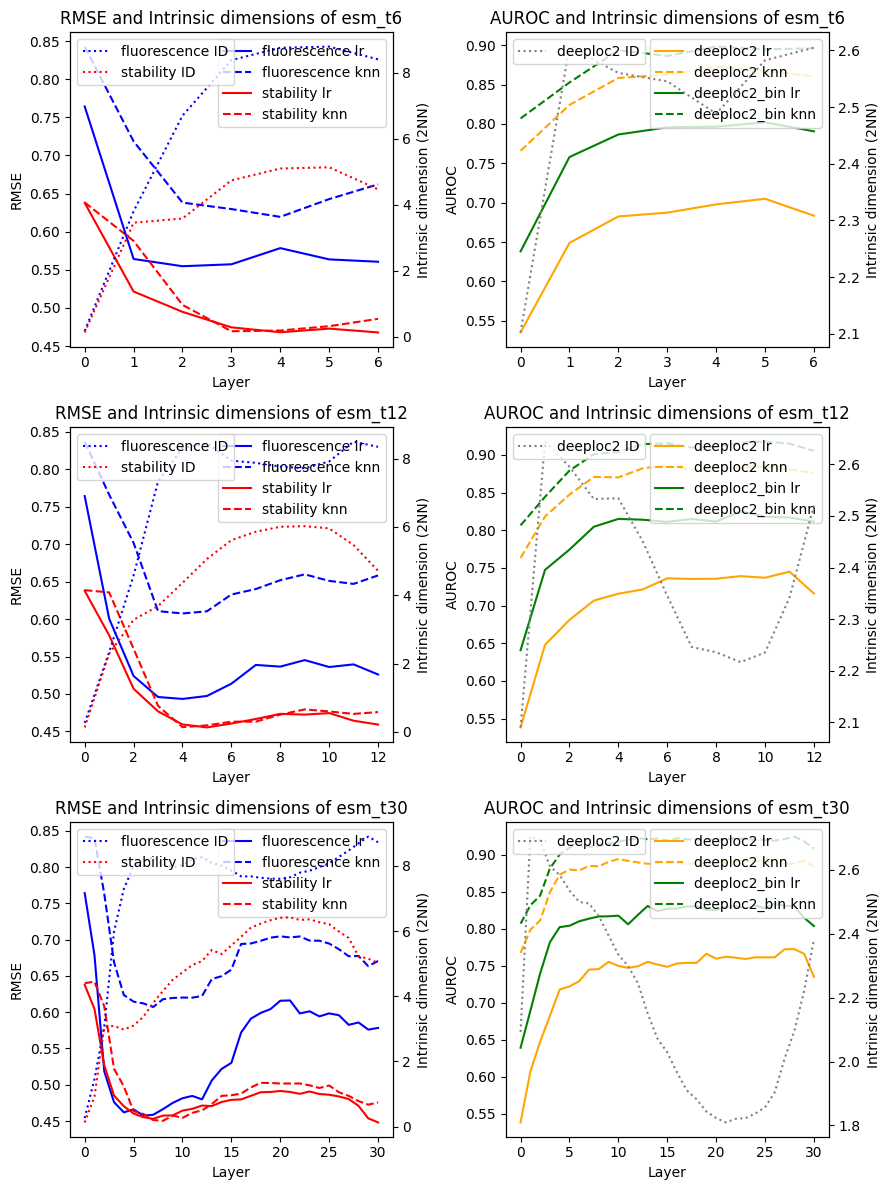

In [4]:
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3, 2, figure=fig)
axs = [
    fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]),
    fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1]),
]

plot_model(axs[0], ROOT, "esm_t6", REG_METRIC)
plot_model(axs[1], ROOT, "esm_t6", CLASS_METRIC, reg=False)

plot_model(axs[2], ROOT, "esm_t12", REG_METRIC)
plot_model(axs[3], ROOT, "esm_t12", CLASS_METRIC, reg=False)

plot_model(axs[4], ROOT, "esm_t30", REG_METRIC)
plot_model(axs[5], ROOT, "esm_t30", CLASS_METRIC, reg=False)

plt.tight_layout()
plt.savefig("figures/page1.pdf", dpi=300)
plt.show()

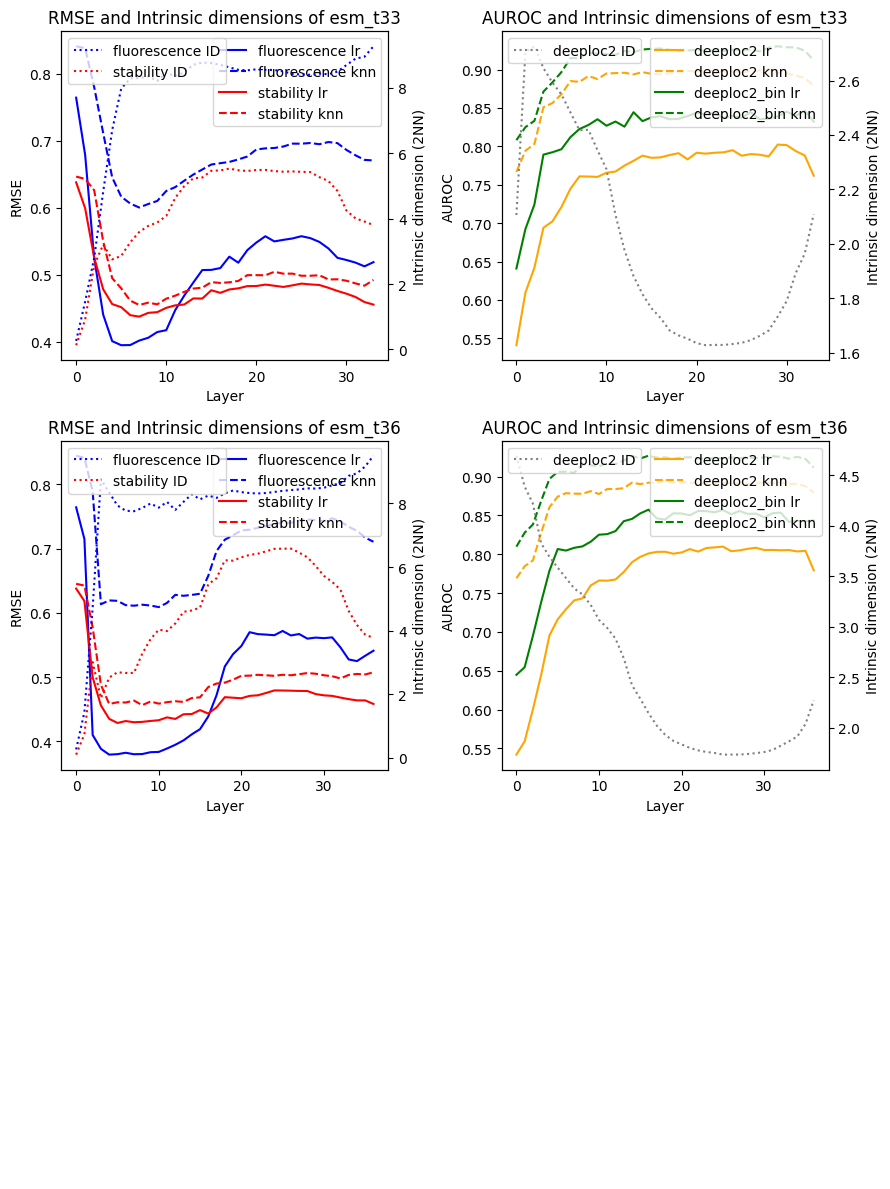

In [5]:
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3, 2, figure=fig)
axs = [
    fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]),
    fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1]),
]

plot_model(axs[0], ROOT, "esm_t33", REG_METRIC)
plot_model(axs[1], ROOT, "esm_t33", CLASS_METRIC, reg=False)

plot_model(axs[2], ROOT, "esm_t36", REG_METRIC)
plot_model(axs[3], ROOT, "esm_t36", CLASS_METRIC, reg=False)

axs[4].set_axis_off()
axs[5].set_axis_off()

plt.tight_layout()
plt.savefig("figures/page2.pdf", dpi=300)
plt.show()

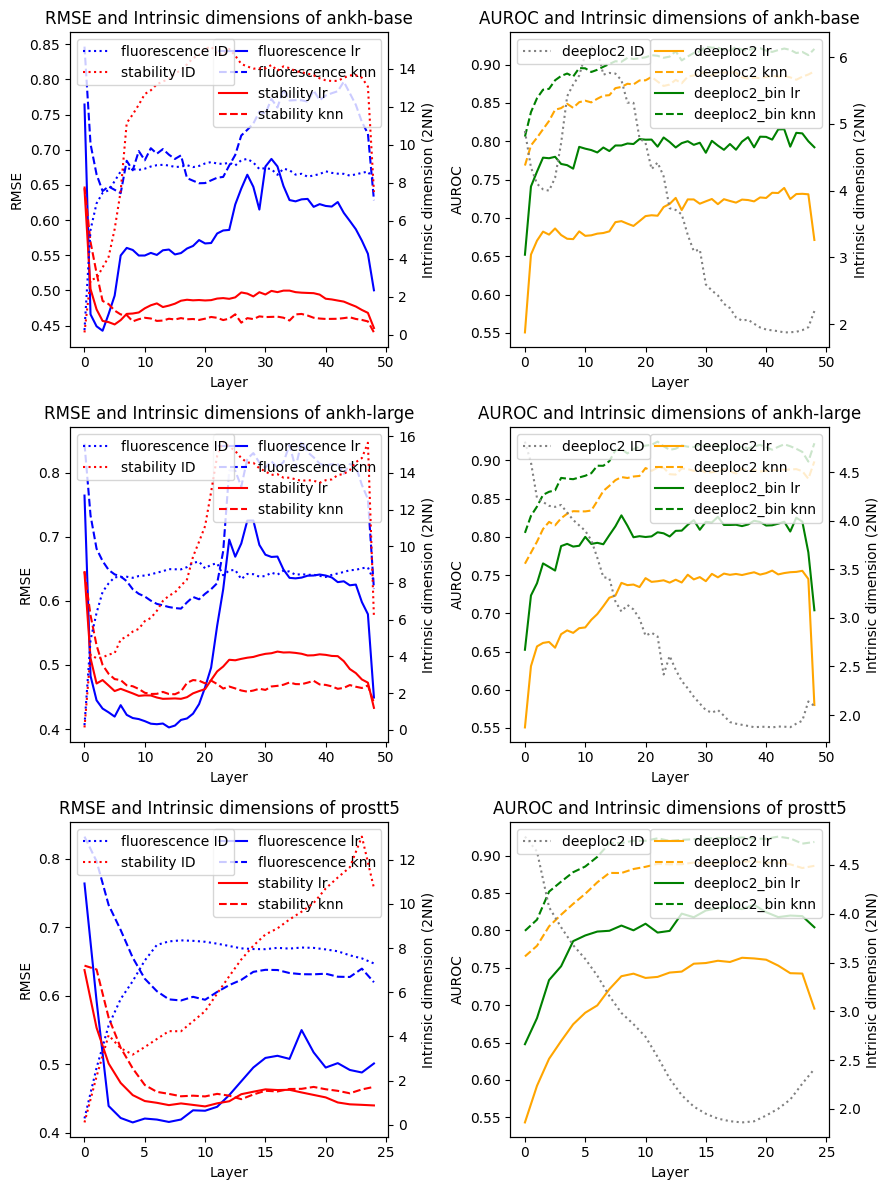

In [6]:
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3, 2, figure=fig)
axs = [
    fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]),
    fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1]),
]

plot_model(axs[0], ROOT, "ankh-base", REG_METRIC)
plot_model(axs[1], ROOT, "ankh-base", CLASS_METRIC, reg=False)

plot_model(axs[2], ROOT, "ankh-large", REG_METRIC)
plot_model(axs[3], ROOT, "ankh-large", CLASS_METRIC, reg=False)

plot_model(axs[4], ROOT, "prostt5", REG_METRIC)
plot_model(axs[5], ROOT, "prostt5", CLASS_METRIC, reg=False)

plt.tight_layout()
plt.savefig("figures/page3.pdf", dpi=300)
plt.show()

In [7]:
DATASET = "fluorescence"
ALGO = "lr"
METRIC = "rmse"
ROOT = Path("/") / "scratch" / "SCRATCH_SAS" / "roman" / "SMTB" / "embeddings"

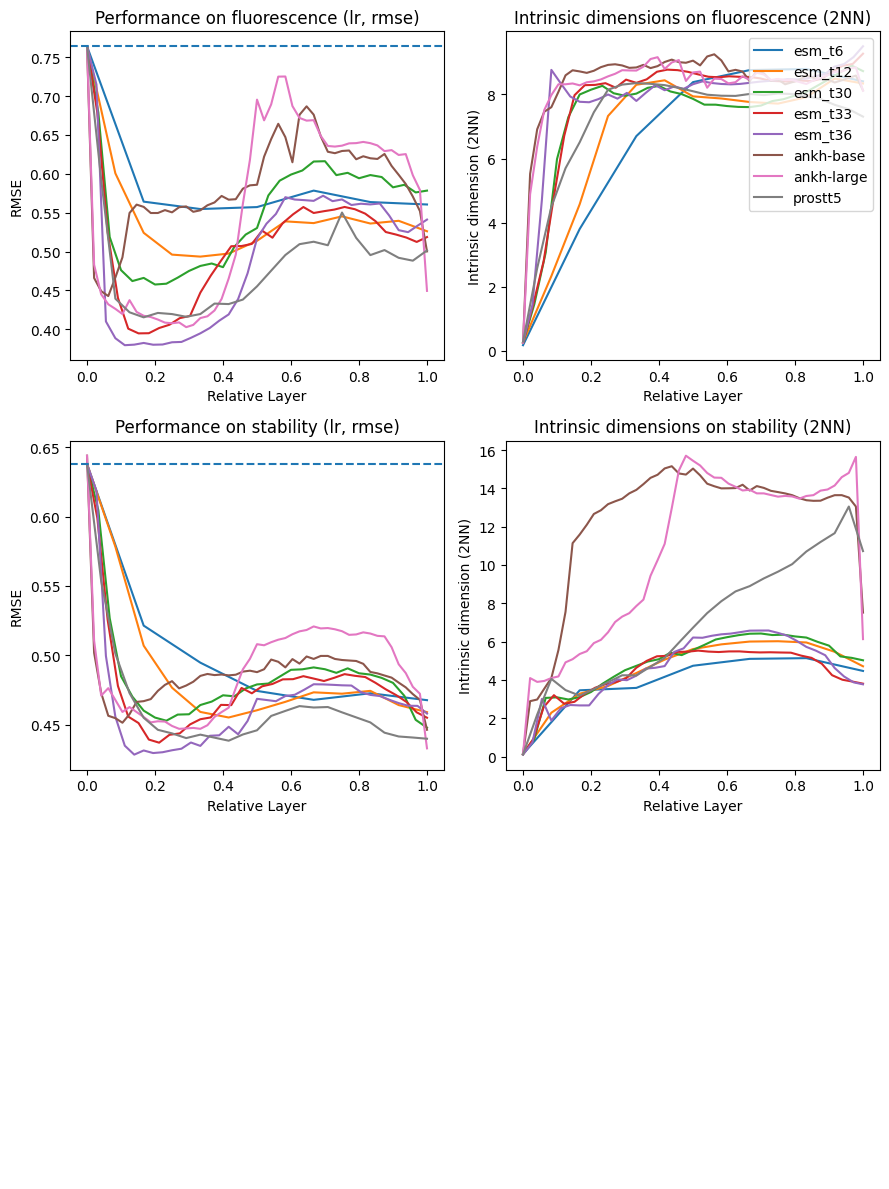

In [8]:
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3, 2, figure=fig)
axs = [
    fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]),
    fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1]),
]

plot_performance(axs[0], ROOT, "fluorescence", ALGO, REG_METRIC, relative=True)
plot_id(axs[1], ROOT, "fluorescence", relative=True, legend=True)
plot_performance(axs[2], ROOT, "stability", ALGO, REG_METRIC, relative=True)
plot_id(axs[3], ROOT, "stability", relative=True)
axs[4].set_axis_off()
axs[5].set_axis_off()

plt.tight_layout()
plt.savefig("figures/page4.pdf", dpi=300)
plt.show()

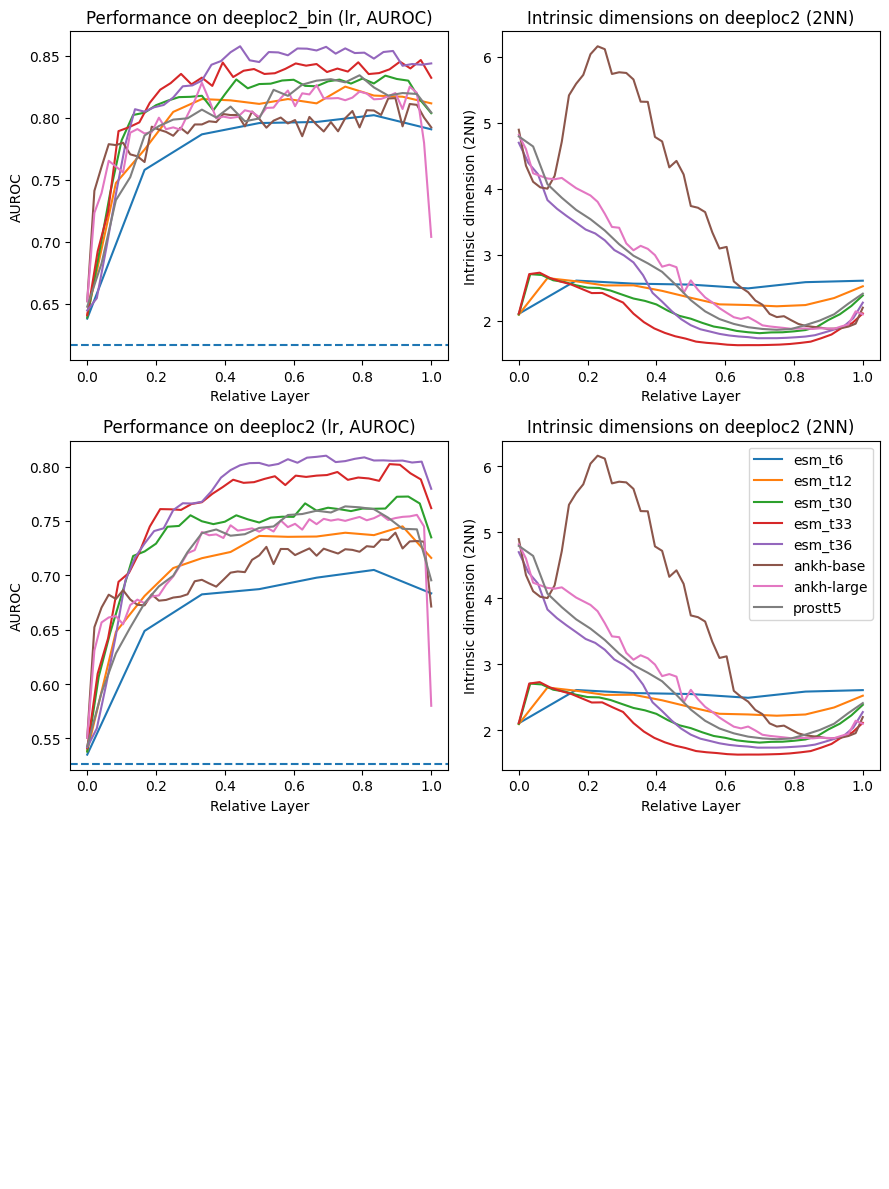

In [9]:
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3, 2, figure=fig)
axs = [
    fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]),
    fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1]),
]

plot_performance(axs[0], ROOT, "deeploc2_bin", ALGO, CLASS_METRIC, relative=True)
plot_id(axs[1], ROOT, "deeploc2", relative=True)
plot_performance(axs[2], ROOT, "deeploc2", ALGO, CLASS_METRIC, relative=True)
plot_id(axs[3], ROOT, "deeploc2", relative=True, legend=True)
axs[4].set_axis_off()
axs[5].set_axis_off()

plt.tight_layout()
plt.savefig("figures/page5.pdf", dpi=300)
plt.show()

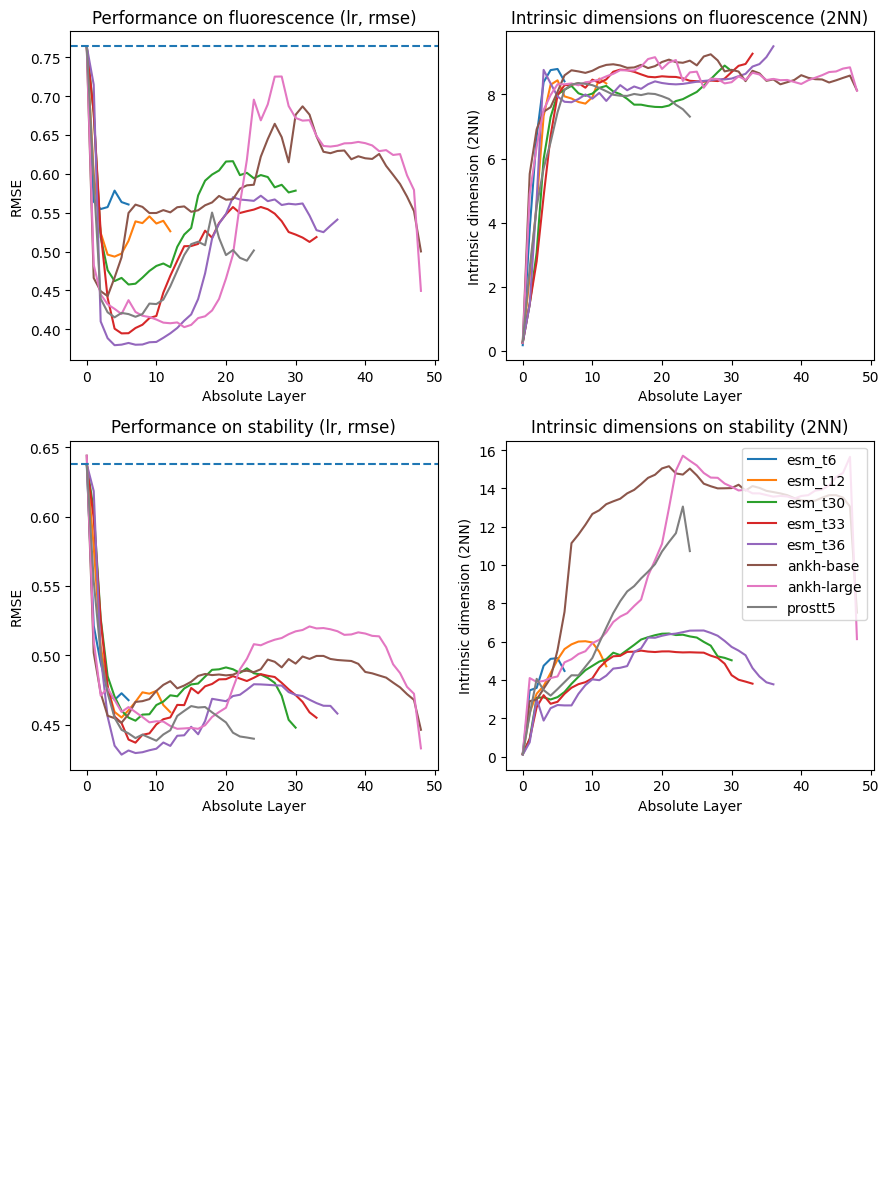

In [10]:
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3, 2, figure=fig)
axs = [
    fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]),
    fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1]),
]

plot_performance(axs[0], ROOT, "fluorescence", ALGO, REG_METRIC, relative=False)
plot_id(axs[1], ROOT, "fluorescence", relative=False)
plot_performance(axs[2], ROOT, "stability", ALGO, REG_METRIC, relative=False)
plot_id(axs[3], ROOT, "stability", relative=False, legend=True)
axs[4].set_axis_off()
axs[5].set_axis_off()

plt.tight_layout()
plt.savefig("figures/page6.pdf", dpi=300)
plt.show()

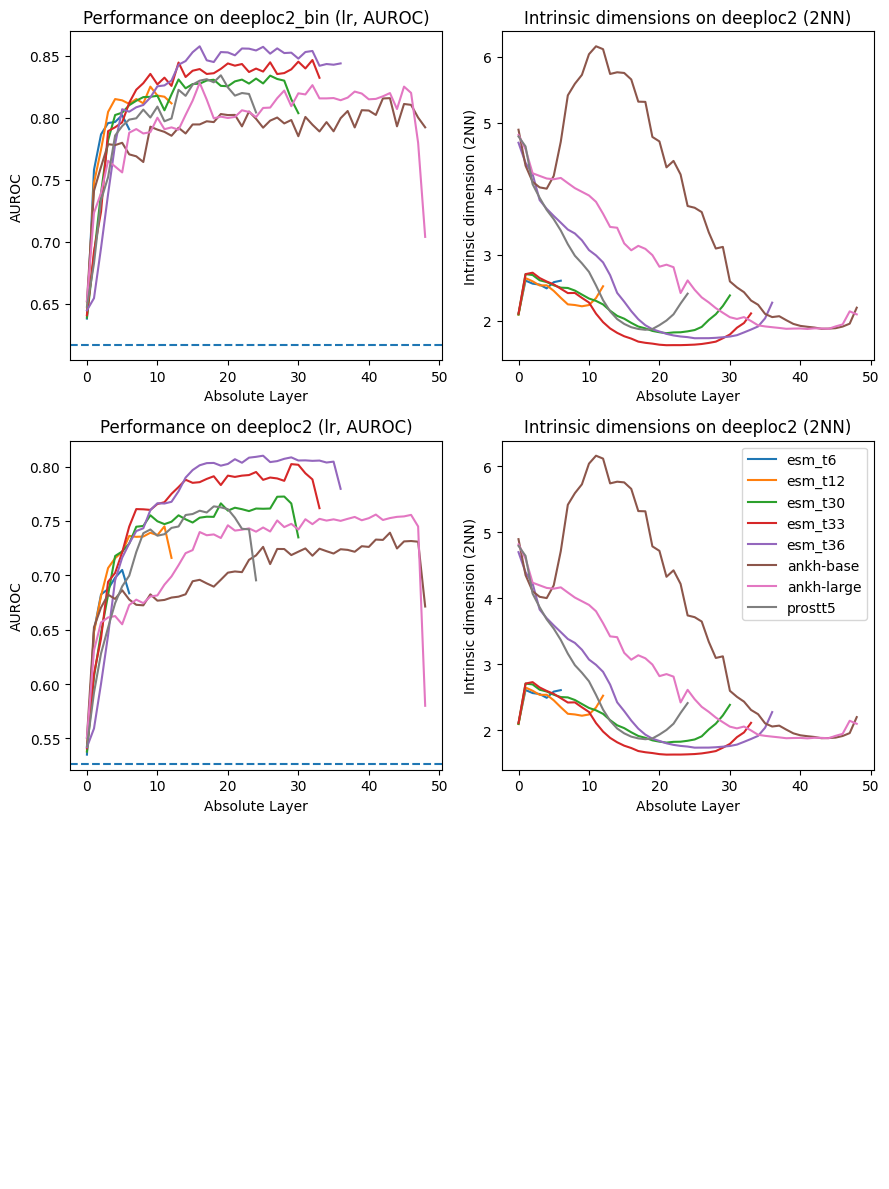

In [11]:
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3, 2, figure=fig)
axs = [
    fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]),
    fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1]),
]

plot_performance(axs[0], ROOT, "deeploc2_bin", ALGO, CLASS_METRIC, relative=False)
plot_id(axs[1], ROOT, "deeploc2", relative=False)
plot_performance(axs[2], ROOT, "deeploc2", ALGO, CLASS_METRIC, relative=False)
plot_id(axs[3], ROOT, "deeploc2", relative=False, legend=True)
axs[4].set_axis_off()
axs[5].set_axis_off()

plt.tight_layout()
plt.savefig("figures/page7.pdf", dpi=300)
plt.show()